## Libraries and data

In [170]:
# Data processing
# ==============================================================================
import numpy as np
import pandas as pd
from skforecast.datasets import fetch_dataset

# Plots
# ==============================================================================
import matplotlib.pyplot as plt
from skforecast.plot import set_dark_theme
from skforecast.plot import plot_residuals
from skforecast.plot import plot_prediction_distribution
from skforecast.plot import plot_prediction_intervals
from pprint import pprint

# Modelling and Forecasting
# ==============================================================================
from lightgbm import LGBMRegressor
from sklearn.pipeline import make_pipeline
from feature_engine.datetime import DatetimeFeatures
from feature_engine.creation import CyclicalFeatures
from skforecast.recursive import ForecasterRecursive
from skforecast.preprocessing import RollingFeatures
from skforecast.model_selection import TimeSeriesFold
from skforecast.model_selection import backtesting_forecaster
from skforecast.metrics import calculate_coverage
from scipy.stats import norm

# Configuration
# ==============================================================================
import warnings
warnings.filterwarnings('once')

# Data processing
# ==============================================================================
import numpy as np
import pandas as pd
from skforecast.datasets import fetch_dataset

# Plots
# ==============================================================================
import matplotlib.pyplot as plt
from skforecast.plot import set_dark_theme
from skforecast.plot import plot_prediction_intervals
from statsmodels.graphics.tsaplots import plot_pacf
from itertools import cycle

# Modelling and Forecasting
# ==============================================================================
from lightgbm import LGBMRegressor
from skforecast.recursive import ForecasterRecursiveMultiSeries
from skforecast.preprocessing import RollingFeatures
from skforecast.model_selection import TimeSeriesFold
from skforecast.model_selection import backtesting_forecaster_multiseries
from skforecast.metrics import calculate_coverage
from skforecast.plot import calculate_lag_autocorrelation

# Configuration
# ==============================================================================
import warnings
warnings.filterwarnings('once')

In [187]:
# Data
# ==============================================================================
data_all = pd.read_parquet('../dev/bdg2_hourly.parquet')
data_all.head(2)

,timestamp,building_id,meter_reading,site_id,primaryspaceusage,sub_primaryspaceusage,sqm,lat,lng,timezone,airTemperature,cloudCoverage,dewTemperature,precipDepth1HR,precipDepth6HR,seaLvlPressure,windDirection,windSpeed
0,2016-01-01 00:00:00,Bear_assembly_Angel,237.85,Bear,Entertainment/public assembly,Entertainment/public assembly,22117.0,37.871903,-122.260729,US/Pacific,4.4,0.0,-2.2,0.0,NaN,1020.9,0.0,0.0
1,2016-01-01 01:00:00,Bear_assembly_Angel,221.25,Bear,Entertainment/public assembly,Entertainment/public assembly,22117.0,37.871903,-122.260729,US/Pacific,4.4,0.0,-4.4,0.0,NaN,1020.5,20.0,2.1


In [191]:
data_all['primaryspaceusage'].unique().tolist()

['Entertainment/public assembly',
 'Education',
 'Lodging/residential',
 'Parking',
 'Public services',
 'Technology/science',
 'Utility',
 'Office',
 'Other',
 'Warehouse/storage',
 'Services',
 'Manufacturing/industrial',
 'Religious worship',
 'Food sales and service',
 'Healthcare',
 'Retail',
 nan]

In [192]:
data_all['sub_primaryspaceusage'].unique().tolist()

['Entertainment/public assembly',
 'Education',
 'Lodging/residential',
 'Parking',
 'Public services',
 'Technology/science',
 'Utility',
 'Sports Facility',
 'Academic',
 'Student Center',
 'Residence Hall/Dormitory',
 'Office',
 'Other',
 'Library',
 'Science Facility',
 'Non-Refrigerated Warehouse',
 'Sports Stadium',
 'Conference Center',
 'Athletic Field',
 'Museum',
 'Theater',
 'Gymnasium',
 'Swimming Pool',
 'College Laboratory',
 'College Classroom',
 'Auditorium',
 'Student Union',
 'Dormitory',
 'office',
 'garage',
 'Community Center',
 'Ice arena',
 'Fitness Center',
 'Greenhouse',
 'Hotel',
 'Religious building',
 'Data Center',
 'Services Plant',
 'Athletic',
 'Research',
 'Classroom',
 'Dining',
 'Support',
 'Patient Care',
 'Housing',
 'Public Service',
 'Planetarium',
 'Primary/Secondary Classroom',
 'Restaurant',
 'Health Services',
 'Parking Garage',
 'Police Station',
 'Chapel',
 'Retail',
 'Central Plant',
 'Warehouse',
 'Park',
 'Recreation Center, Community Cen

/tmp/ipykernel_18694/2049061751.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['timestamp'] = pd.to_datetime(data['timestamp'])


building_id,Hog_health_Hisako,Hog_health_Jenny,Hog_health_Kesha,Mouse_health_Buddy,Mouse_health_Estela,Mouse_health_Ileana,Mouse_health_Justin,Mouse_health_Modesto
timestamp,,,,,,,,
2016-06-01 00:00:00,214.753,164.167,215.475,17.6449,314.0,28.0,657.960,663.223
2016-06-01 01:00:00,214.014,162.459,215.651,17.6449,293.0,28.0,665.861,650.274


array([<Axes: xlabel='timestamp'>, <Axes: xlabel='timestamp'>,
       <Axes: xlabel='timestamp'>, <Axes: xlabel='timestamp'>,
       <Axes: xlabel='timestamp'>, <Axes: xlabel='timestamp'>,
       <Axes: xlabel='timestamp'>, <Axes: xlabel='timestamp'>],
      dtype=object)

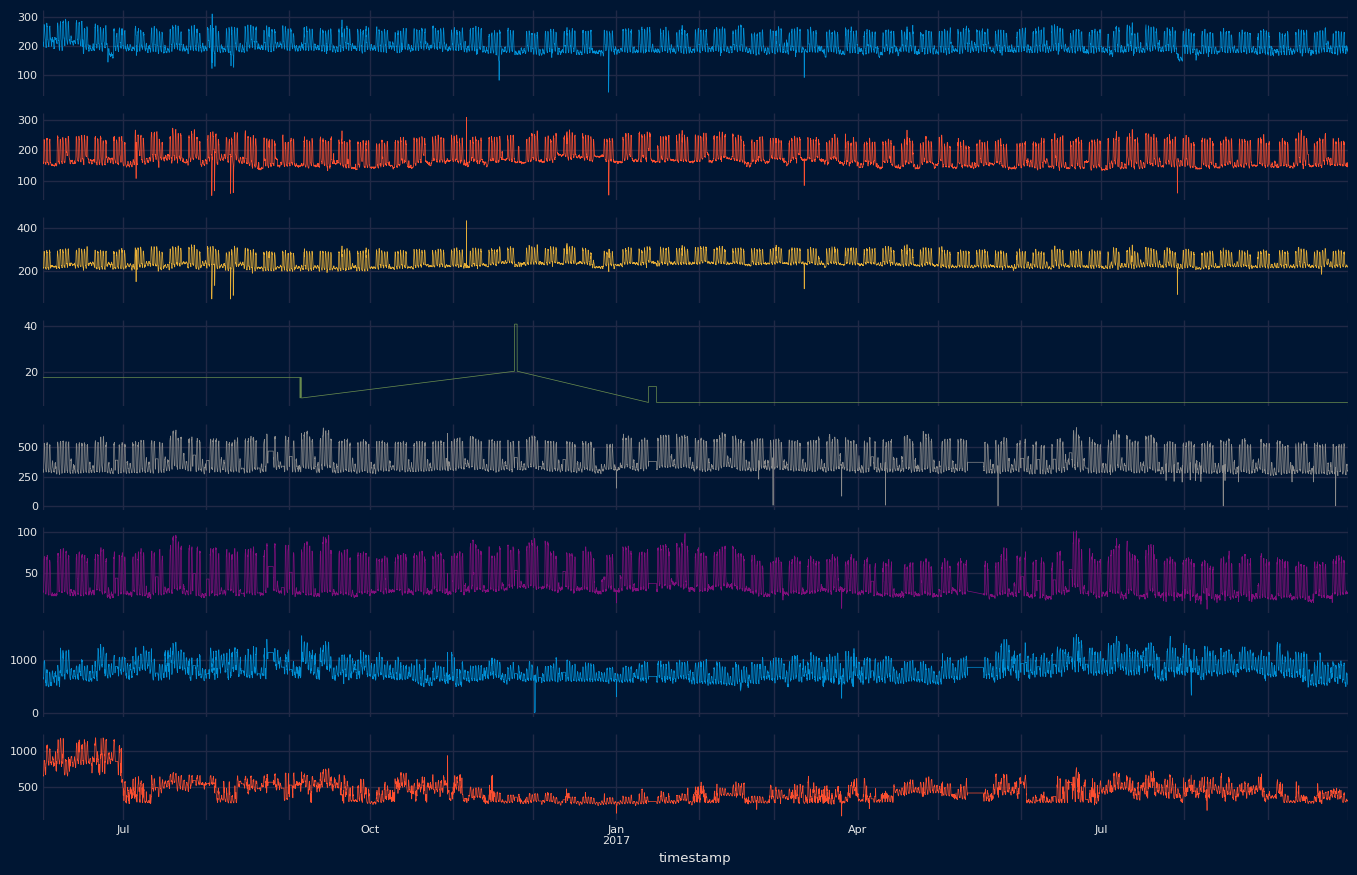

In [197]:
ids = ['Wolf_education_Tori', 'Wolf_education_Ursula', 'Wolf_education_Vivian']
data = data_all[data_all['sub_primaryspaceusage'] == 'Hospital']
#data = data_all[data_all['building_id'].isin(ids)].copy()
data['timestamp'] = pd.to_datetime(data['timestamp'])
data = data.pivot_table(index='timestamp', columns='building_id', values='meter_reading')
data = data.asfreq('h')
data = data.interpolate(method='linear')
data = data.loc['2016-06-01':'2017-09-30'].copy()
data = data.interpolate(method='linear')
# data.columns = [f"building_{i+1}" for i in range(data.shape[1])]
display(data.head(2))
data.plot(subplots=True, figsize=(15, 10), legend=False)

In [171]:
data = fetch_dataset(name="bdg2_hourly_sample")
data = data.interpolate(method='linear')
data = data.loc['2017-01-01':'2017-09-30']
data = data[['building_2']]
data.head(2)

bdg2_hourly_sample
------------------
Daily energy consumption data of three buildings sampled from the The Building
Data Genome Project 2. https://github.com/buds-lab/building-data-genome-
project-2
Miller, C., Kathirgamanathan, A., Picchetti, B. et al. The Building Data Genome
Project 2, energy meter data from the ASHRAE Great Energy Predictor III
competition. Sci Data 7, 368 (2020). https://doi.org/10.1038/s41597-020-00712-x
Shape of the dataset: (17544, 3)


,building_2
timestamp,
2017-01-01 00:00:00,164.725
2017-01-01 01:00:00,162.677


In [172]:
data['building_2'] = np.where(data['building_2'] < 100, np.nan, data['building_2'])
data = data.interpolate(method='linear')
data

,building_2
timestamp,
2017-01-01 00:00:00,164.725
2017-01-01 01:00:00,162.677
2017-01-01 02:00:00,164.001
2017-01-01 03:00:00,164.565
2017-01-01 04:00:00,164.313
...,...
2017-09-30 19:00:00,160.705
2017-09-30 20:00:00,152.793
2017-09-30 21:00:00,148.792


In [173]:
data['day_of_week'] = data.index.dayofweek
data['hour'] = data.index.hour

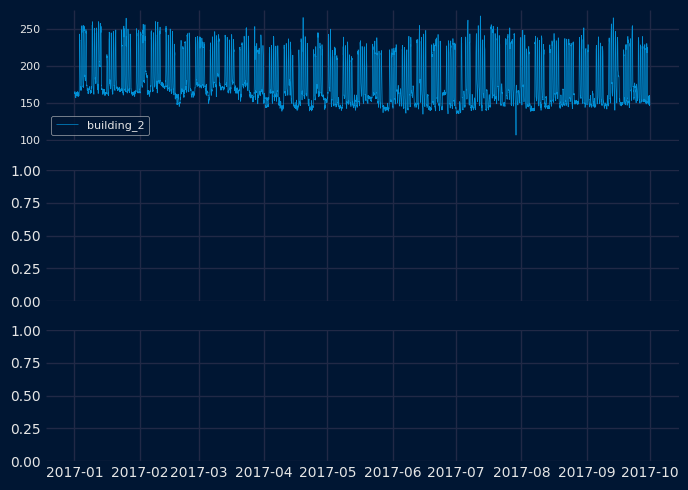

In [174]:
# Plot time series
# ==============================================================================
set_dark_theme()
plt.rcParams['lines.linewidth'] = 0.5
colors = cycle(plt.rcParams['axes.prop_cycle'].by_key()['color'])
fig, axs = plt.subplots(3, 1, figsize=(7, 5), sharex=True)
series = ['building_2']
for i, col in enumerate(series):
    axs[i].plot(data[col], label=col, color=next(colors))
    axs[i].legend(loc='lower left', fontsize=8)
    axs[i].tick_params(axis='both', labelsize=8)

plt.tight_layout()

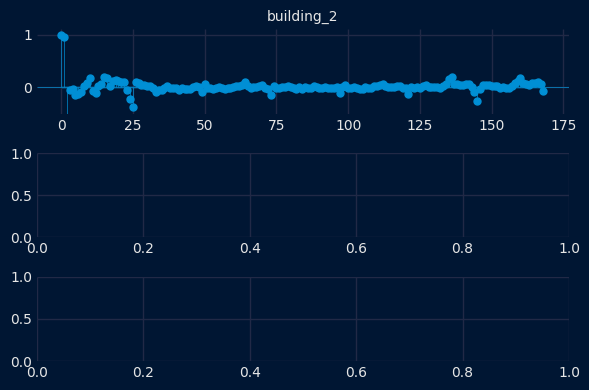

In [175]:
# Partial autocorrelation values and plots
# ==============================================================================
n_lags = 24 * 7
pacf_df = []

fig, axs = plt.subplots(3, 1, figsize=(6, 4))
axs = axs.ravel()
for i, col in enumerate(series):
    pacf_values = calculate_lag_autocorrelation(data[col], n_lags=n_lags)
    pacf_values['variable'] = col
    pacf_df.append(pacf_values)
    
    plot_pacf(data[col], lags=n_lags, ax=axs[i])
    axs[i].set_title(col, fontsize=10)
    axs[i].set_ylim(-0.5, 1.1)

plt.tight_layout()

In [176]:
# Top n lags with highest absolute partial autocorrelation per variable
# ==============================================================================
n = 10
top_lags = set()
for pacf_values in pacf_df:
    variable = pacf_values['variable'].iloc[0]
    lags = pacf_values.nlargest(n, 'partial_autocorrelation_abs')['lag'].sort_values().tolist()
    top_lags.update(lags)
    print(f"{variable}: {lags}")

top_lags = list(top_lags)
top_lags.sort()
print(f"\nAll lags: {top_lags}")

building_2: [1, 2, 10, 15, 16, 24, 25, 136, 145, 160]

All lags: [1, 2, 10, 15, 16, 24, 25, 136, 145, 160]


In [177]:
# Split train-validation-test
# ==============================================================================
end_train = '2017-06-01 23:59:00'
end_validation = '2017-08-30 23:59:00'
data_train = data.loc[: end_train, :]
data_val   = data.loc[end_train:end_validation, :]
data_test  = data.loc[end_validation:, :]

print(f"Dates train      : {data_train.index.min()} --- {data_train.index.max()}  (n={len(data_train)})")
print(f"Dates validacion : {data_val.index.min()} --- {data_val.index.max()}  (n={len(data_val)})")
print(f"Dates test       : {data_test.index.min()} --- {data_test.index.max()}  (n={len(data_test)})")

Dates train      : 2017-01-01 00:00:00 --- 2017-06-01 23:00:00  (n=3648)
Dates validacion : 2017-06-02 00:00:00 --- 2017-08-30 23:00:00  (n=2160)
Dates test       : 2017-08-31 00:00:00 --- 2017-09-30 23:00:00  (n=744)


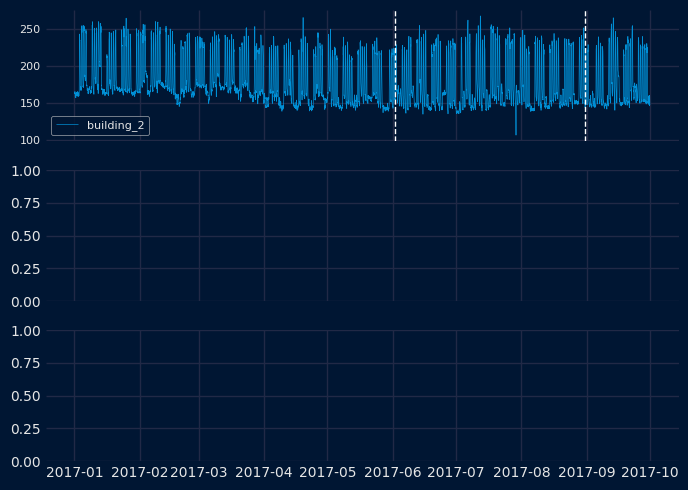

In [178]:
# Plot partitions
# ==============================================================================
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
fig, axs = plt.subplots(3, 1, figsize=(7, 5), sharex=True)
for i, col in enumerate(series):
    axs[i].plot(data[col], label=col, color=colors[i])
    axs[i].legend(loc='lower left', fontsize=8)
    axs[i].tick_params(axis='both', labelsize=8)
    axs[i].axvline(pd.to_datetime(end_train), color='white', linestyle='--', linewidth=1)  # End train
    axs[i].axvline(pd.to_datetime(end_validation), color='white', linestyle='--', linewidth=1)  # End validation

plt.tight_layout()

## Intervals with In-sample residuals

By default, intervals can be computed using in-sample residuals (residuals from the training set), either by calling the `predict_interval()` method, or by performing a full [backtesting](../user_guides/backtesting.html) procedure. However, this can result in intervals that are too narrow (overly optimistic).

In [179]:
# Create and fit forecaster
# ==============================================================================
exog_features = ['day_of_week', 'hour']

params = {
    "n_estimators": 300,
    "learning_rate": 0.1,
    "max_depth": 5,
    "linear_tree": True,
}
window_features = RollingFeatures(stats=["mean", "min", "max"], window_sizes=24)
forecaster = ForecasterRecursive(
                 regressor       = LGBMRegressor(random_state=15926, verbose=-1, **params),
                 lags            = lags,
                 window_features = window_features,
                 binner_kwargs   = {'n_bins': 3},
             )

forecaster.fit(
    y    = data.loc[:end_validation, 'building_2'],
    exog = data.loc[:end_validation, exog_features]
)

In [180]:
# Backtesting on validation data to obtain out-sample residuals
# ==============================================================================
cv = TimeSeriesFold(
         initial_train_size = len(data.loc[:end_train, :]),
         steps              = 48,  # all hours of next day
     )

metric_val, predictions_val = backtesting_forecaster(
                                  forecaster    = forecaster,
                                  y        = data.loc[:end_validation, 'building_2'],
                                  exog          = data.loc[:end_validation, exog_features],
                                  cv            = cv,
                                  metric        = 'mean_absolute_error',
                                  n_jobs        = 'auto',
                                  verbose       = False,
                                  show_progress = True
                              )

  0%|          | 0/45 [00:00<?, ?it/s]

positive    1116
negative    1044
Name: count, dtype: int64


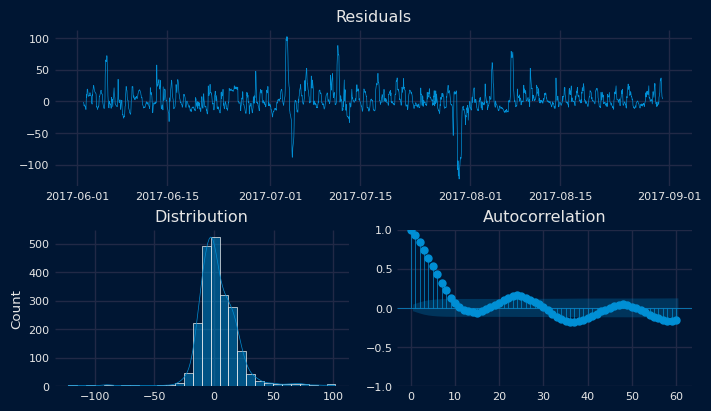

In [181]:
# Out-sample residuals distribution
# ==============================================================================
residuals = data.loc[predictions_val.index, 'building_2'] - predictions_val['pred']
print(pd.Series(np.where(residuals < 0, 'negative', 'positive')).value_counts())
plt.rcParams.update({'font.size': 8})
_ = plot_residuals(residuals=residuals, figsize=(7, 4))

In [182]:
# Store out-sample residuals in the forecaster
# ==============================================================================
forecaster.set_out_sample_residuals(
    y_true = data.loc[predictions_val.index, 'building_2'], 
    y_pred = predictions_val['pred']
)

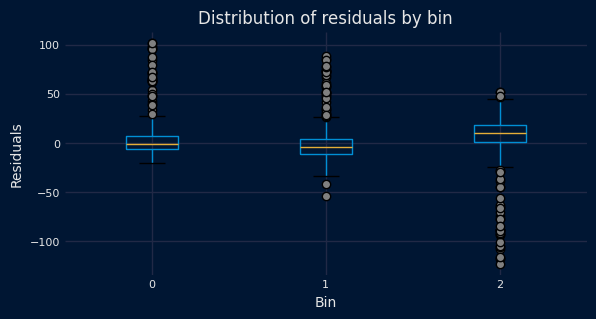

In [183]:
# Distribution of the residual by bin
# ==============================================================================
out_sample_residuals_by_bin_df = pd.DataFrame(
    dict(
        [(k, pd.Series(v))
         for k, v in forecaster.out_sample_residuals_by_bin_.items()]
    )
)
fig, ax = plt.subplots(figsize=(6, 3))
out_sample_residuals_by_bin_df.boxplot(
    flierprops=dict(marker='o', markerfacecolor='gray', markersize=6),
    ax=ax
)
ax.set_title("Distribution of residuals by bin", fontsize=12)
ax.set_xlabel("Bin", fontsize=10)
ax.set_ylabel("Residuals", fontsize=10)
plt.show();

In [184]:
# Backtesting with prediction intervals in test data using out-sample residuals
# ==============================================================================
cv = TimeSeriesFold(
         steps              = 48, 
         initial_train_size = len(data.loc[:end_validation]),
         refit              = False
     )

metric, predictions = backtesting_forecaster(
                          forecaster              = forecaster,
                          y                       = data['building_2'],
                          exog                    = data[exog_features],
                          cv                      = cv,
                          metric                  = 'mean_absolute_error',
                          interval                = [10, 90],  # 80% prediction interval
                          interval_method         = 'bootstrapping',
                          n_boot                  = 150,
                          use_in_sample_residuals = False,  # Use out-sample residuals
                          use_binned_residuals    = True,
                          n_jobs                  = 'auto',
                          verbose                 = False,
                          show_progress           = True
                      )
predictions.head(5)

  0%|          | 0/16 [00:00<?, ?it/s]

,pred,lower_bound,upper_bound
2017-08-31 00:00:00,151.360478,140.851855,167.048582
2017-08-31 01:00:00,148.898920,134.771811,194.681038
2017-08-31 02:00:00,145.805899,130.156856,213.468675
2017-08-31 03:00:00,144.801882,129.652988,243.452330
2017-08-31 04:00:00,143.276857,123.353761,244.221213


Predicted interval coverage: 99.46 %
Area of the interval: 89013.29


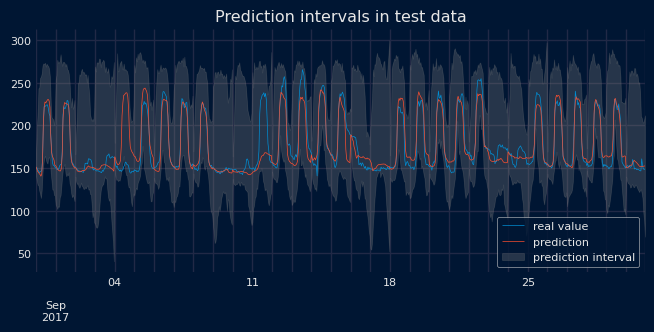

In [185]:
# Plot intervals
# ==============================================================================
plot_prediction_intervals(
    predictions         = predictions,
    y_true              = data_test,
    target_variable     = "building_2",
    title               = "Prediction intervals in test data",
    kwargs_fill_between = {'color': 'gray', 'alpha': 0.3, 'zorder': 1}
)

# Predicted interval coverage (on test data)
# ==============================================================================
coverage = calculate_coverage(
               y_true      = data.loc[end_validation:, 'building_2'],
               lower_bound = predictions["lower_bound"], 
               upper_bound = predictions["upper_bound"]
           )
print(f"Predicted interval coverage: {round(100 * coverage, 2)} %")

# Area of the interval
# ==============================================================================
area = (predictions["upper_bound"] - predictions["lower_bound"]).sum()
print(f"Area of the interval: {round(area, 2)}")